<a href="https://colab.research.google.com/github/bkvkrll/Python-Libraries-for-Data-Science-Continued/blob/main/Python_Libraries_for_Data_Science_Continued.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

     |████████████████████████████████| 69.2 MB 4.8 kB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as catb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
TRAIN_DATASET_FILE = './course_project_train.csv'
TEST_DATASET_FILE = './course_project_test.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_FILE)
df_test = pd.read_csv(TEST_DATASET_FILE)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
print(f"Train:\t{df_train.shape[0]}\t sales and {df_train.shape[1]} features")
print(f'Test:\t{df_test.shape[0]}\t sales and {df_test.shape[1]} features')

Train:	7500	 sales and 17 features
Test:	2500	 sales and 16 features


In [6]:
# Функция первоначального анализа переменных
def initial_analysis(X):
  print(df_train[X].value_counts())

  print(df_train.corrwith(df_train[X]))

  df_train[X].hist(figsize=(16, 8), bins=20, grid=False)

  plt.figure(figsize=(10, 8))
  sns.countplot(x=X, hue="Credit Default", data=df_train)
  plt.title('\"X\" grouped by target variable')
  plt.legend(title='Target', loc='upper right')
  plt.show()

  

In [7]:
# Функция оптимизации памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [12]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [13]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [14]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

In [15]:
all_data = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)
all_data.drop(['Credit Default'], axis=1, inplace=True)

In [16]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,7930.0,1.366525e+06,8.638284e+05,106533.0,845989.25,1168813.5,1638693.00,1.497561e+07
Tax Liens,10000.0,3.140000e-02,3.043327e-01,0.0,0.00,0.0,0.00,1.500000e+01
Number of Open Accounts,10000.0,1.114430e+01,4.894754e+00,1.0,8.00,10.0,14.00,4.800000e+01
Years of Credit History,10000.0,1.831961e+01,7.095358e+00,3.9,13.50,17.0,22.00,5.770000e+01
Maximum Open Credit,10000.0,8.865069e+05,1.389973e+07,0.0,278811.50,478181.0,794359.50,1.304726e+09
Number of Credit Problems,10000.0,1.680000e-01,5.145906e-01,0.0,0.00,0.0,0.00,1.500000e+01
Months since last delinquent,4561.0,3.456457e+01,2.177195e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,9983.0,1.145948e-01,3.497299e-01,0.0,0.00,0.0,0.00,5.000000e+00
Current Loan Amount,10000.0,1.194376e+07,3.200875e+07,11242.0,180548.50,311718.0,521070.00,1.000000e+08
Current Credit Balance,10000.0,2.914740e+05,3.339973e+05,0.0,113225.75,209019.0,361950.00,6.506797e+06


In [17]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [18]:
cat_features = df_train.select_dtypes(include='category').columns.tolist()
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [19]:
for col in cat_features:
    print(col, df_train[col].value_counts(), '\n', sep='\n')

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


Term
Short Term    5556
Long Term     1944
Name: Term, dtype: int64




In [20]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [21]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Объекты с пропусками в тренировочном и тестовом датасетах совпадают

Пробуем обучить модель на представленных данных без обработки

In [22]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = ['']
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [23]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Years in current job    category
Home Ownership          category
Purpose                 category
Term                    category
dtype: object

In [24]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES 

X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

In [25]:
#Используем CatBoost, чтоб иметь возможность использовать данные в первоначальном виде  

model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3768
           1       0.98      0.50      0.67      1482

    accuracy                           0.86      5250
   macro avg       0.91      0.75      0.79      5250
weighted avg       0.88      0.86      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1619
           1       0.74      0.26      0.38       631

    accuracy                           0.77      2250
   macro avg       0.75      0.61      0.62      2250
weighted avg       0.76      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1561   58
1                467  164


# **Обработка пропусков и выбросов**

**Home Ownership**

In [26]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Home Mortgage - Ипотека дома,
Rent - Аренда,
Own Home - Собственный дом,
Have Mortgage - Ипотека.

Вероятно Home Mortgage и Have Mortgage одно и тоже, возможно ошибка возникла из-за опечатки

In [27]:
df_train['Home Mortgage'] = 0
df_train['Rent'] = 0
df_train['Own Home'] = 0

df_train.loc[(df_train['Home Ownership'] == 'Home Mortgage') |\
             (df_train['Home Ownership'] == 'Have Mortgage'), 'Home Mortgage'] = 1
df_train.loc[df_train['Home Ownership'] == 'Rent', 'Rent'] = 1
df_train.loc[df_train['Home Ownership'] == 'Own Home', 'Own Home'] = 1

df_train.drop(['Home Ownership'], axis='columns', inplace=True)

In [28]:
df_test['Home Mortgage'] = 0
df_test['Rent'] = 0
df_test['Own Home'] = 0

df_test.loc[(df_test['Home Ownership'] == 'Home Mortgage') |\
             (df_test['Home Ownership'] == 'Have Mortgage'), 'Home Mortgage'] = 1
df_test.loc[df_test['Home Ownership'] == 'Rent', 'Rent'] = 1
df_test.loc[df_test['Home Ownership'] == 'Own Home', 'Own Home'] = 1

df_test.drop(['Home Ownership'], axis='columns', inplace=True)

In [29]:
df_train.value_counts()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Months since last delinquent  Bankruptcies  Purpose             Term        Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  Home Mortgage  Rent  Own Home
10149344.0     5 years               0.0        10.0                     17.500000                270380.0             0.0                        22.0                          0.0           debt consolidation  Short Term  664818.0             205713.0                61235.0       692.0         0               0              1     0           1
1038578.0      10+ years             0.0        14.0                     38.099998                459800.0             1.0                        65.0                          1.0           business loan       Short Term  42944.0              336357.0                11476.0       738.0         1               0 

In [30]:
df_train.isna().sum()

Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Home Mortgage                      0
Rent                               0
Own Home                           0
dtype: int64

**Years in current job**

In [31]:
df_train['Years in current job'].isna().value_counts()

False    7129
True      371
Name: Years in current job, dtype: int64

In [32]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Можно предположить, что пропуски стоят у того, кто рабоает меньше одного года.Заменим пропуски на значение <1 года


In [33]:
df_train['Years in current job Nan'] = 0
df_train.loc[df_train['Years in current job'].isna(),\
             'Years in current job Nan'] = 1
df_train.loc[df_train['Years in current job'].isna(),\
             'Years in current job'] = '< 1 year'

In [34]:
df_test['Years in current job Nan'] = 0
df_test.loc[df_test['Years in current job'].isna(),\
             'Years in current job Nan'] = 1
df_test.loc[df_test['Years in current job'].isna(),\
             'Years in current job'] = '< 1 year'

In [35]:
df_train['Years in current job'].isna().value_counts()

False    7500
Name: Years in current job, dtype: int64

In [36]:
# Создаем отдельные категории для этого признака

df_train['Years in current job'] = df_train['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(int)

In [37]:
df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(int)

In [38]:
df_train['Years in current job'].isna().value_counts()

False    7500
Name: Years in current job, dtype: int64

**Tax Liens**

In [39]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

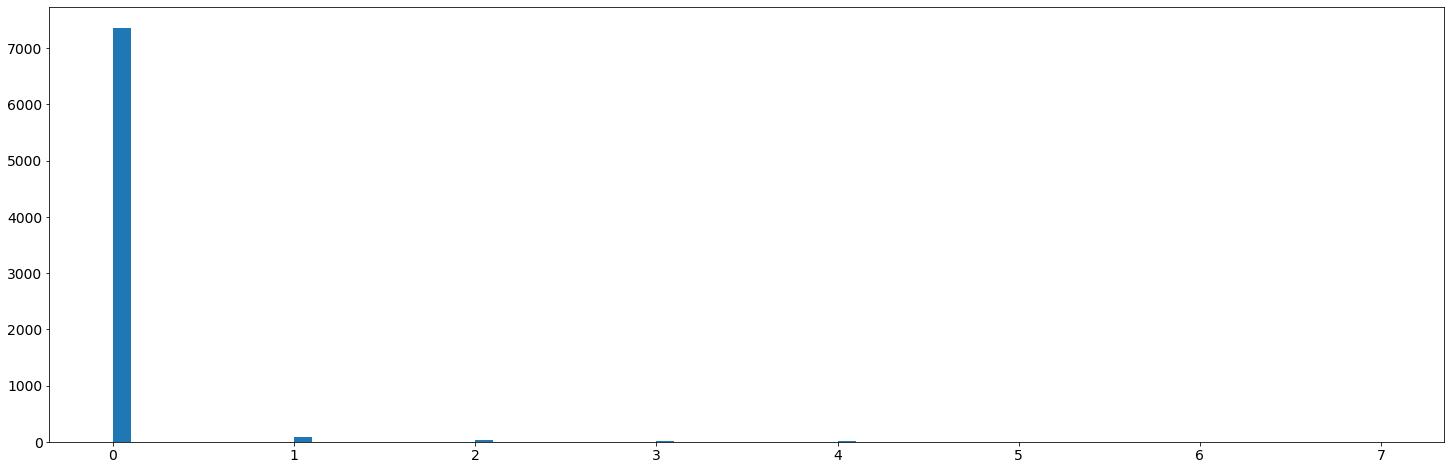

In [40]:
df_train['Tax Liens'].hist(figsize=(25, 8), bins=70, grid=False);

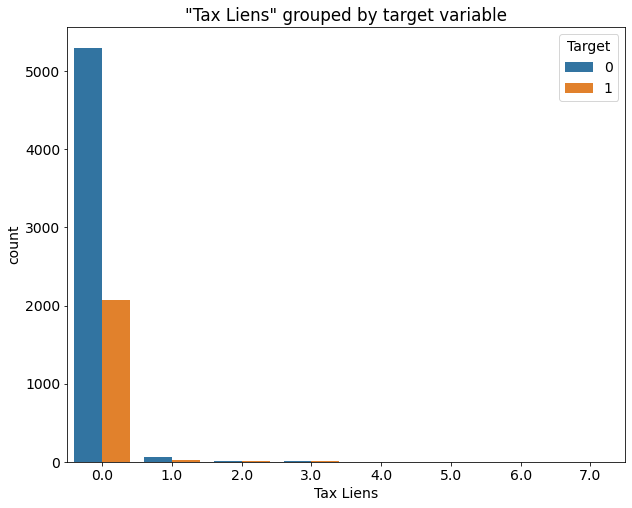

In [41]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Tax Liens", hue="Credit Default", data=df_train)
plt.title('\"Tax Liens\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [42]:
df_train['Tax Liens'].describe()

count    7500.000000
mean        0.030133
std         0.271613
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

Признаки с третьего по седьмой очень малы по сравнению с 0, поэтому объединим их в признак 2 и оставим 3 категории

In [43]:
df_train.loc[df_train['Tax Liens'] > 2, 'Tax Liens'] = 2

In [44]:
df_test.loc[df_test['Tax Liens'] > 2, 'Tax Liens'] = 2

In [45]:
df_train['Tax Liens'] = df_train['Tax Liens'].map({2:0,
                                                   1:1,
                                                   0:2}).astype(int)

In [46]:
df_test['Tax Liens'] = df_test['Tax Liens'].map({2:0,
                                                   1:1,
                                                   0:2}).astype(int)

In [47]:
df_train['Tax Liens'].value_counts()

2    7366
1      83
0      51
Name: Tax Liens, dtype: int64

**Number of Open Accounts**

In [48]:
df_train['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

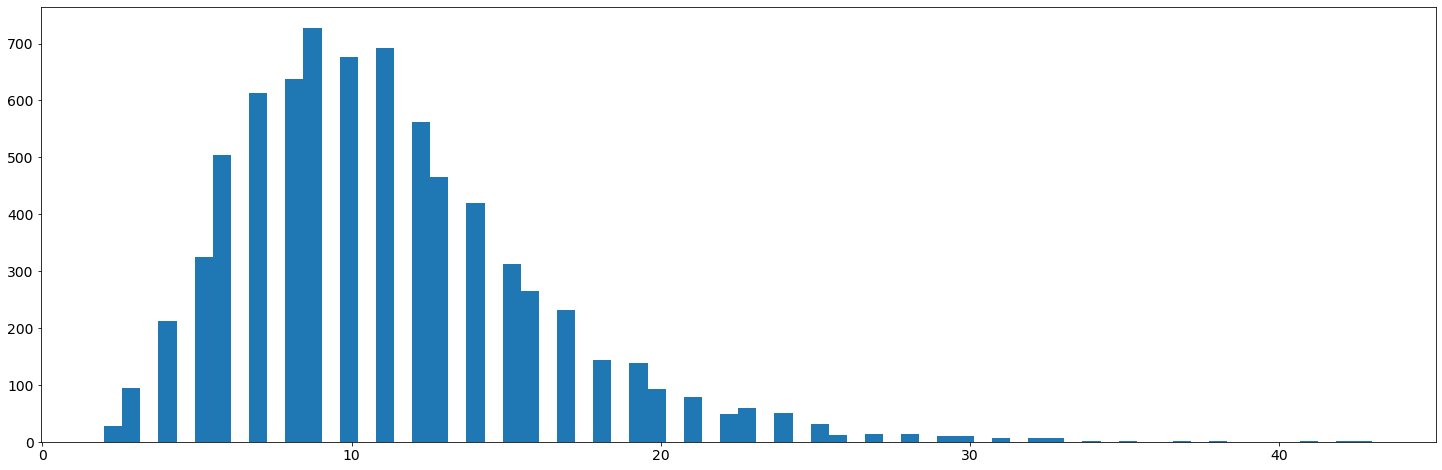

In [49]:
df_train['Number of Open Accounts'].hist(figsize=(25, 8), bins=70, grid=False);

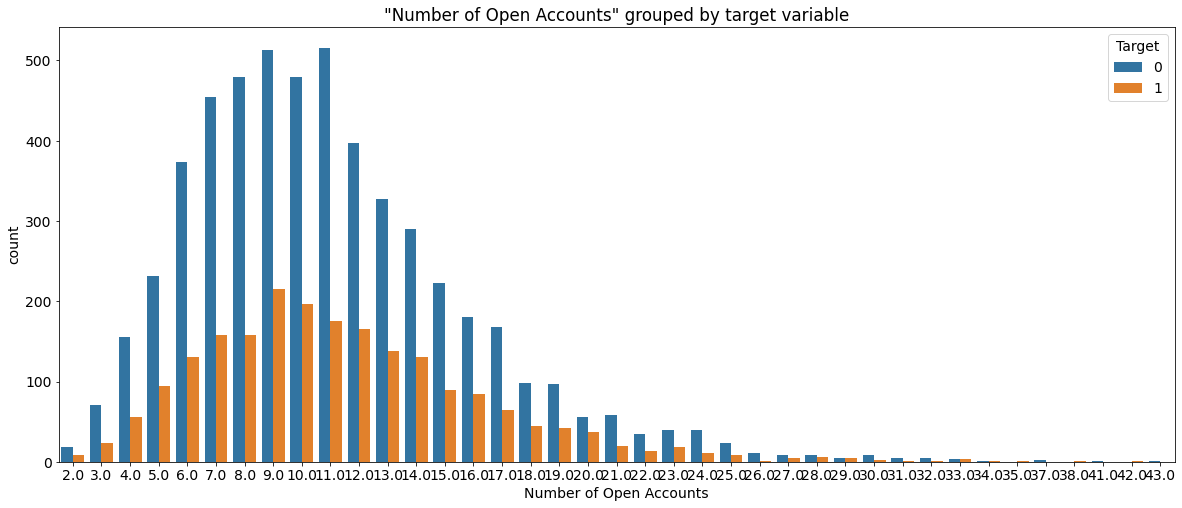

In [50]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Number of Open Accounts", hue="Credit Default", data=df_train)
plt.title('\"Number of Open Accounts\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [51]:
df_train['Number of Open Accounts'].quantile(.975), df_train['Number of Open Accounts'].quantile(.025)

(23.0, 4.0)

In [52]:
condition = (df_train['Number of Open Accounts'].isna()) \
             | (df_train['Number of Open Accounts'] > df_train['Number of Open Accounts'].quantile(.975))
        
df_train.loc[condition, 'Number of Open Accounts'] = df_train['Number of Open Accounts'].median()

In [53]:
condition = (df_test['Number of Open Accounts'].isna()) \
             | (df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.975))
        
df_test.loc[condition, 'Number of Open Accounts'] = df_test['Number of Open Accounts'].median()

In [54]:
df_train['Number of Open Accounts'].value_counts()

10.0    847
9.0     728
11.0    692
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
22.0     49
2.0      28
Name: Number of Open Accounts, dtype: int64

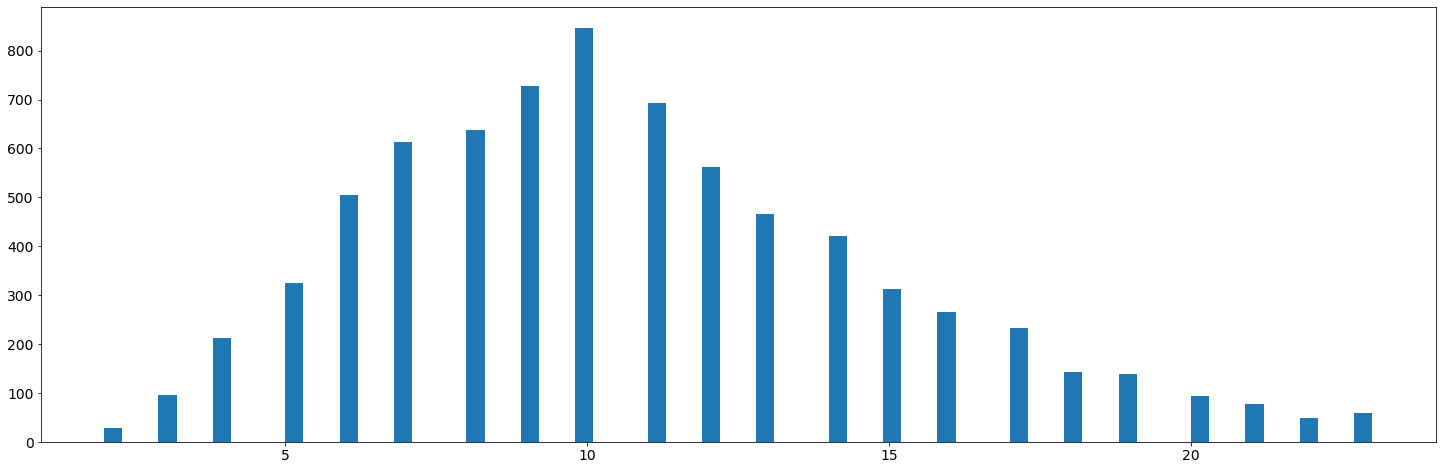

In [55]:
df_train['Number of Open Accounts'].hist(figsize=(25, 8), bins=70, grid=False);

**Years of Credit History**

In [56]:
df_train['Years of Credit History'].value_counts()

15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
40.099998      1
39.500000      1
50.900002      1
44.299999      1
38.500000      1
Name: Years of Credit History, Length: 408, dtype: int64

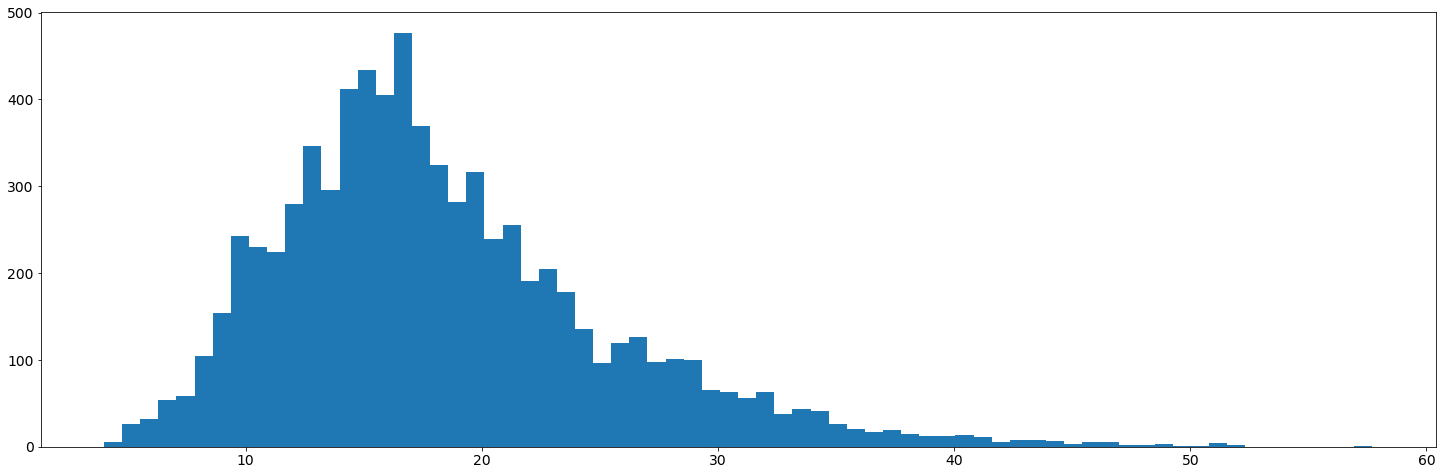

In [57]:
df_train['Years of Credit History'].hist(figsize=(25, 8), bins=70, grid=False);

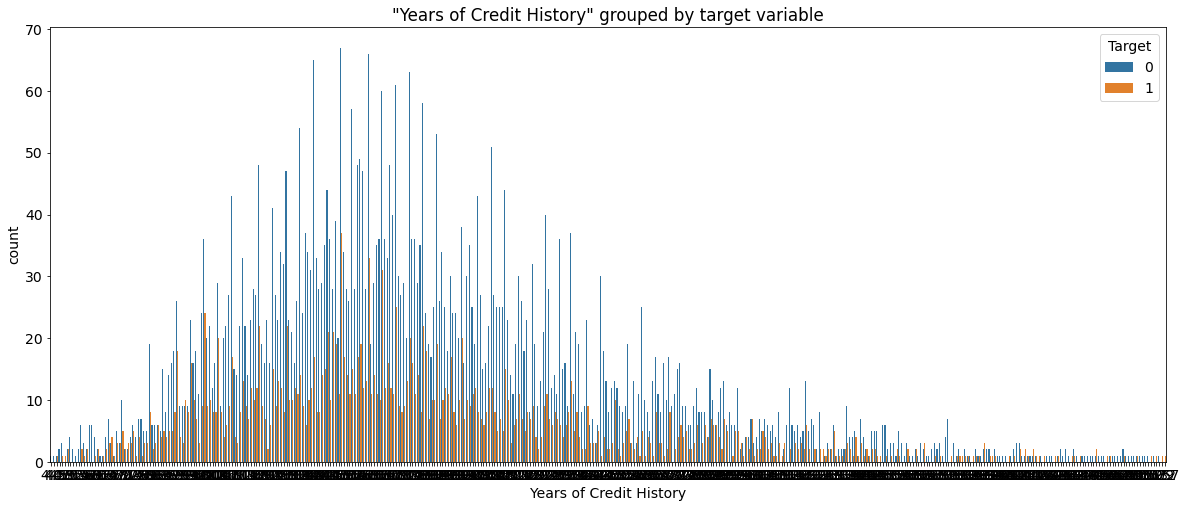

In [58]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Years of Credit History", hue="Credit Default", data=df_train)
plt.title('\"Years of Credit History\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [59]:
df_train['Years of Credit History'].quantile(.975), df_train['Years of Credit History'].quantile(.025)

(35.20000076293945, 8.0)

In [60]:
condition = (df_train['Years of Credit History'].isna()) \
             | (df_train['Years of Credit History'] > df_train['Years of Credit History'].quantile(.975))
        
df_train.loc[condition, 'Years of Credit History'] = df_train['Years of Credit History'].median()

In [61]:
condition = (df_test['Years of Credit History'].isna()) \
             | (df_test['Years of Credit History'] > df_test['Years of Credit History'].quantile(.975))
        
df_test.loc[condition, 'Years of Credit History'] = df_test['Years of Credit History'].median()

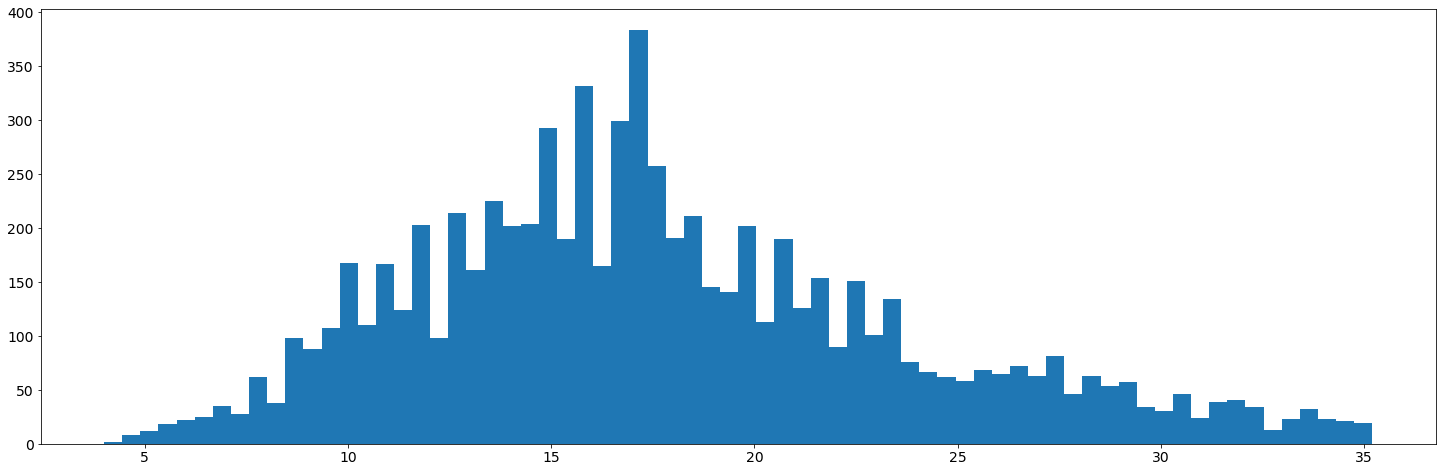

In [62]:
df_train['Years of Credit History'].hist(figsize=(25, 8), bins=70, grid=False);

**Maximum Open Credit**

In [63]:
df_train['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

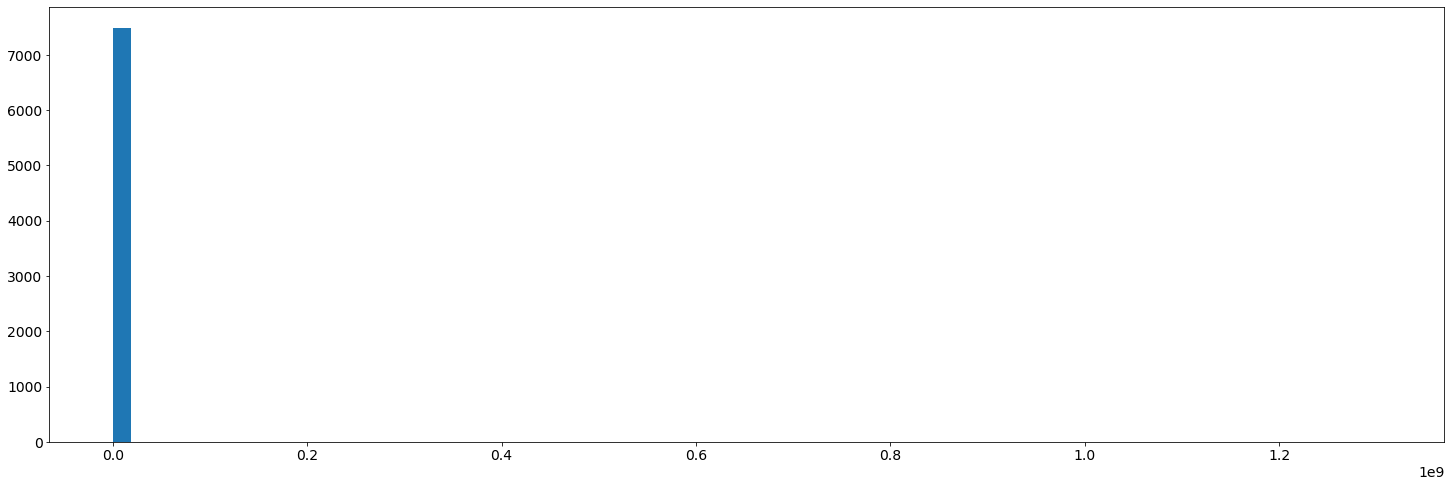

In [64]:
df_train['Maximum Open Credit'].hist(figsize=(25, 8), bins=70, grid=False);

In [65]:
df_train['Maximum Open Credit'].quantile(.975), df_train['Maximum Open Credit'].quantile(.025)

(2236204.2999999984, 70912.6)

In [66]:
condition = (df_train['Maximum Open Credit'].isna()) \
             | (df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(.975))
        
df_train.loc[condition, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()

In [67]:
condition = (df_test['Maximum Open Credit'].isna()) \
             | (df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.975))
        
df_test.loc[condition, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].median()

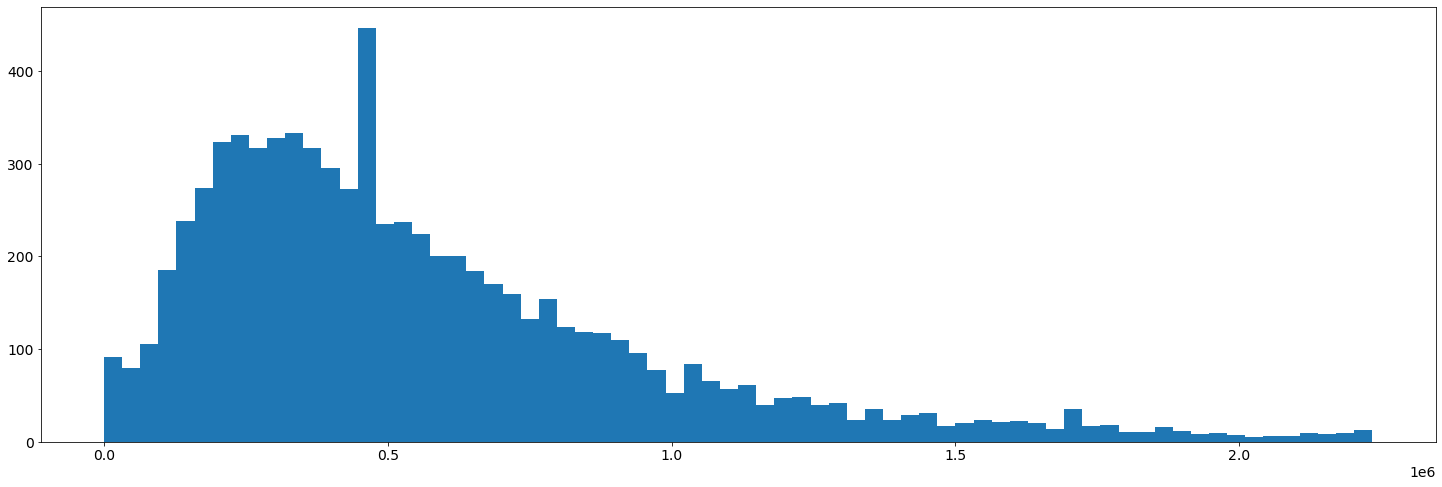

In [68]:
df_train['Maximum Open Credit'].hist(figsize=(25, 8), bins=70, grid=False);

**Number of Credit Problems**

In [69]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

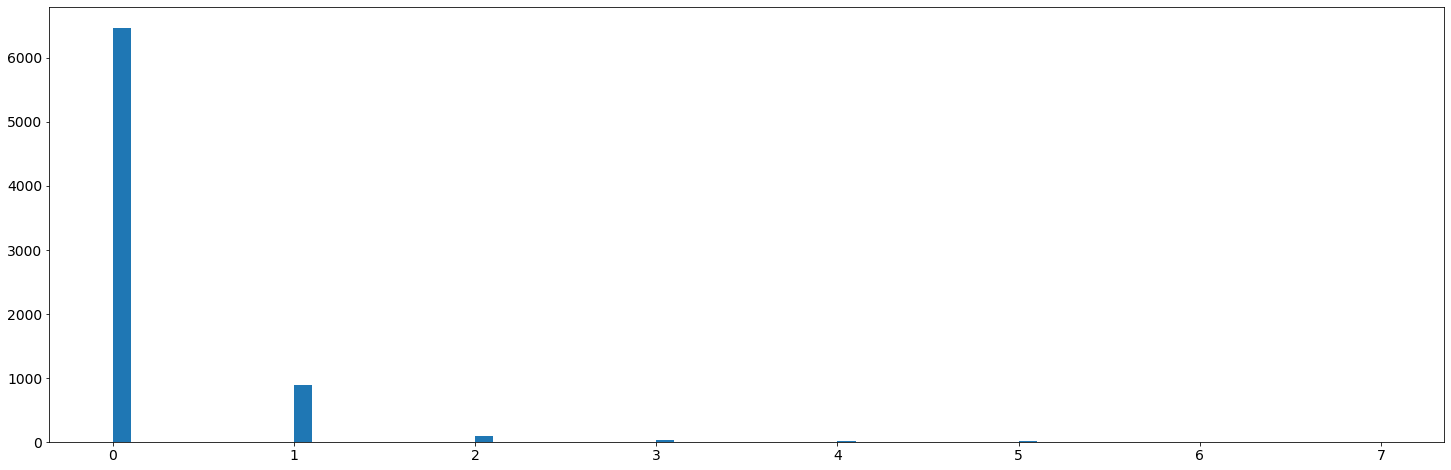

In [70]:
df_train['Number of Credit Problems'].hist(figsize=(25, 8), bins=70, grid=False);

Признаки с третьего по седьмой очень малы по сравнению с 0, поэтому объединим их в признак 2 и оставим 3 категории

In [71]:
df_train.loc[df_train['Number of Credit Problems'] > 2, 'Number of Credit Problems'] = 2

In [72]:
df_test.loc[df_test['Number of Credit Problems'] > 2, 'Number of Credit Problems'] = 2

In [73]:
df_train['Number of Credit Problems'] = df_train['Number of Credit Problems'].map({2:0,
                                                                                   1:1,
                                                                                   0:2}).astype(int)

In [74]:
df_test['Number of Credit Problems'] = df_test['Number of Credit Problems'].map({2:0,
                                                                                 1:1,
                                                                                 0:2}).astype(int)

In [75]:
df_train['Number of Credit Problems'].value_counts()

2    6469
1     882
0     149
Name: Number of Credit Problems, dtype: int64

**Months since last delinquent**

In [76]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [77]:
df_train['Months since last delinquent'].isna().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

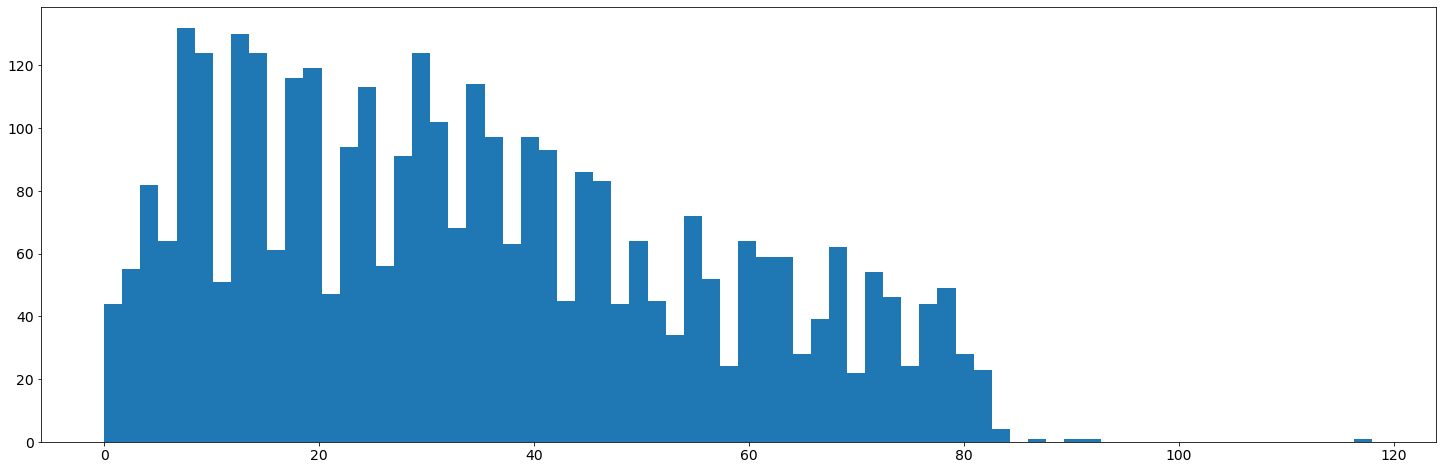

In [78]:
df_train['Months since last delinquent'].hist(figsize=(25, 8), bins=70, grid=False);

Предположу,что пропуски в данном критерии означают то, что просрочек по текущам платежам нет, поэтому заменю пропуски нулями

In [79]:
df_train.loc[df_train['Months since last delinquent'].isna(),'Months since last delinquent'] = 0

In [80]:
df_test.loc[df_test['Months since last delinquent'].isna(),'Months since last delinquent'] = 0

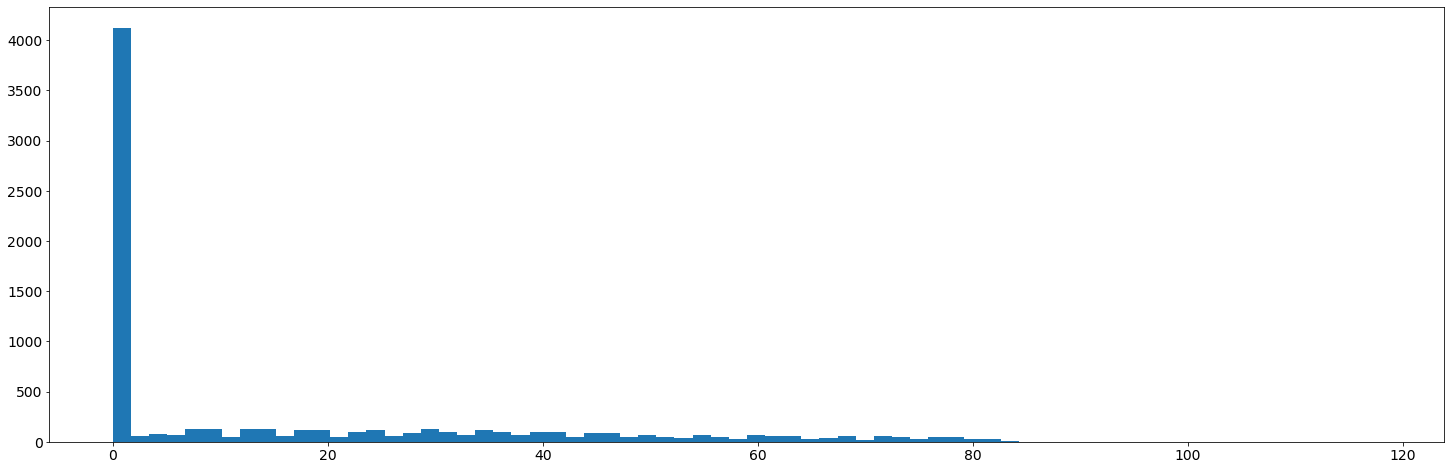

In [81]:
df_train['Months since last delinquent'].hist(figsize=(25, 8), bins=70, grid=False);

In [82]:
df_train['Months since last delinquent'].isna().value_counts()

False    7500
Name: Months since last delinquent, dtype: int64

**Bankruptcies**

In [83]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [84]:
df_train['Bankruptcies'].isna().value_counts()

False    7486
True       14
Name: Bankruptcies, dtype: int64

Предположу,что пропуски в данном критерии означают то, что банкротства нет, поэтому заменю пропуски нулями

In [85]:
df_train.loc[df_train['Bankruptcies'].isna(),'Bankruptcies'] = 0

In [86]:
df_test.loc[df_test['Bankruptcies'].isna(),'Bankruptcies'] = 0

In [87]:
df_train['Bankruptcies'].isna().value_counts()

False    7500
Name: Bankruptcies, dtype: int64

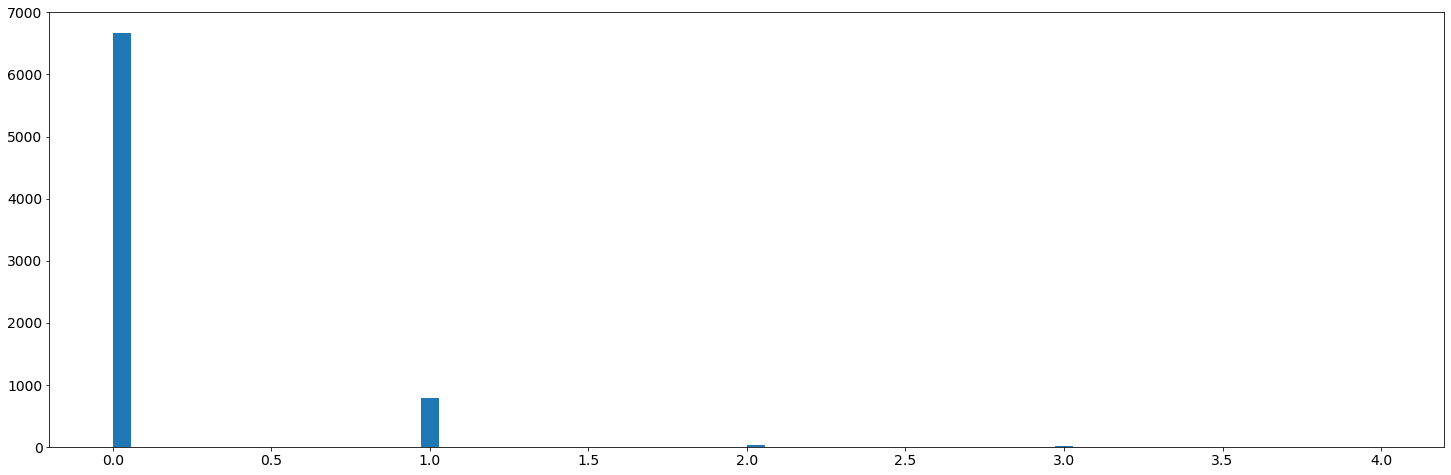

In [88]:
df_train['Bankruptcies'].hist(figsize=(25, 8), bins=70, grid=False);

Фактически клмент может быть либо банкротом либо нет, значения 2 и 3 могут означать что было несколько процедур или попыток банкротства. Поэтому думаю, что можно объединить все что выше 0 в одну категорию

In [89]:
df_train.loc[(df_train['Bankruptcies'] > 1), 'Bankruptcies'] = 1

In [90]:
df_test.loc[(df_test['Bankruptcies'] > 1), 'Bankruptcies'] = 1

In [91]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     826
Name: Bankruptcies, dtype: int64

**Purpose**

In [92]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

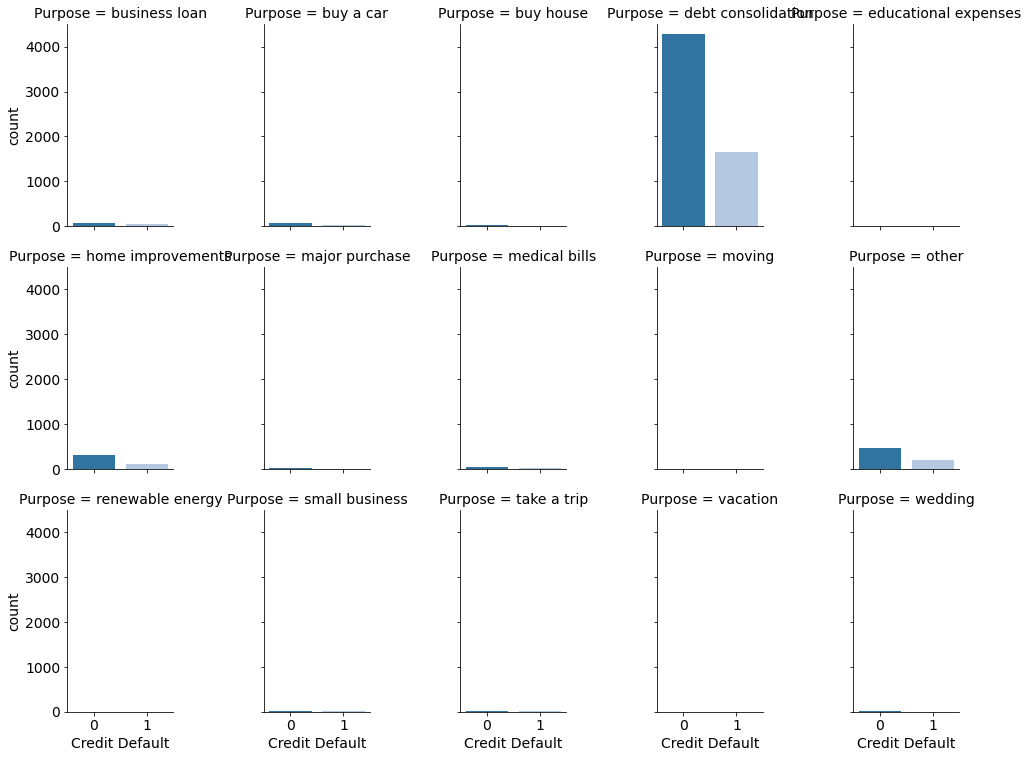

In [93]:
g = sns.catplot("Credit Default", col="Purpose", col_wrap=5,
                data=df_train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
plt.show()

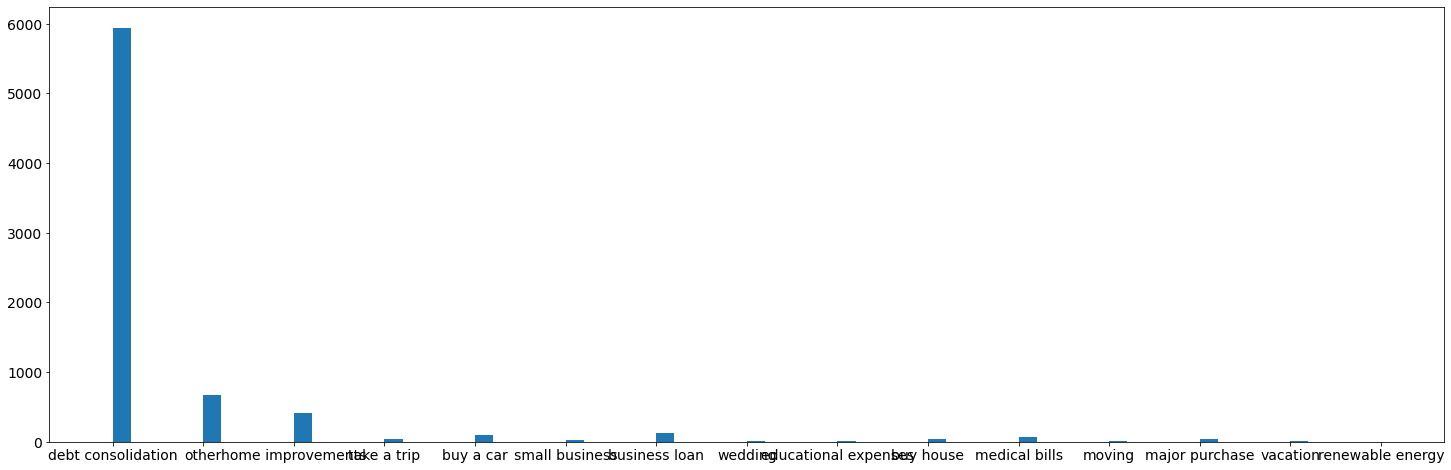

In [94]:
df_train['Purpose'].hist(figsize=(25, 8), bins=70, grid=False);

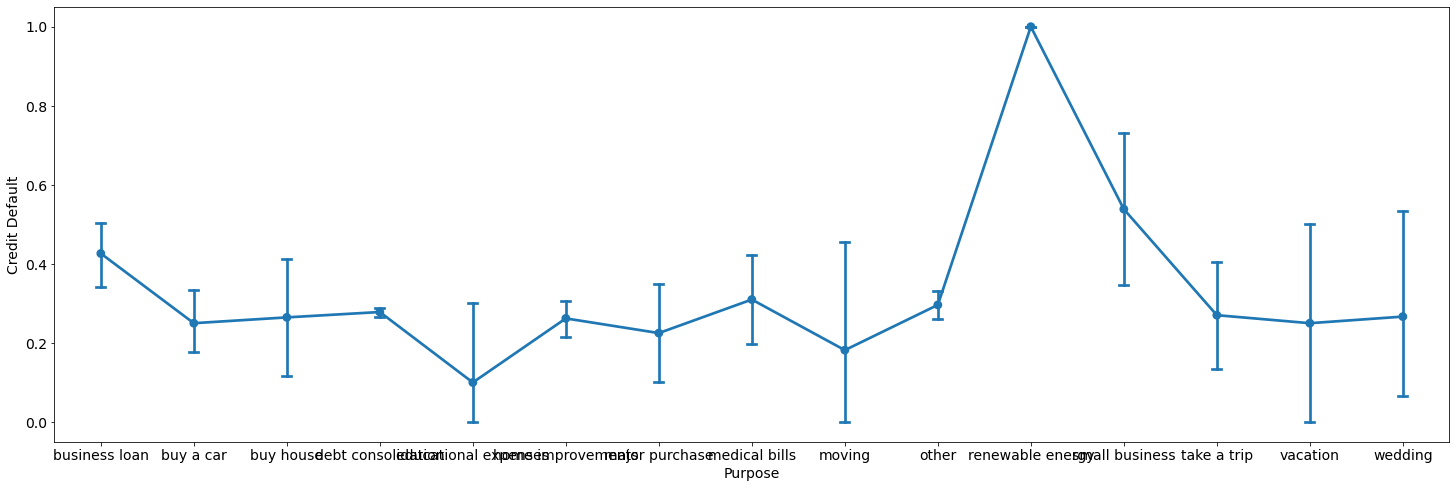

In [95]:
plt.figure(figsize=(25, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,);

Разобьем все нужды на 4 группы: 
1 - финансирование
2 - прочее
3 - дом
4 - бизнес

In [96]:
df_train['Purpose'] = df_train['Purpose'].map({
                                'debt consolidation':'1', 
                                'other':'2',
                                'home improvements':'3',
                                'business loan':'4',
                                'buy a car':'3',
                                'medical bills':'2',
                                'major purchase':'3',
                                'take a trip':'2',
                                'buy house':'3',
                                'small business':'4',
                                'wedding':'2',
                                'moving':'3',
                                'educational expenses':'2',
                                'vacation':'2',
                                'renewable energy':'2'
                                }).astype(int)

In [97]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'1', 
                                'other':'2',
                                'home improvements':'3',
                                'business loan':'4',
                                'buy a car':'3',
                                'medical bills':'2',
                                'major purchase':'3',
                                'take a trip':'2',
                                'buy house':'3',
                                'small business':'4',
                                'wedding':'2',
                                'moving':'3',
                                'educational expenses':'2',
                                'vacation':'2',
                                'renewable energy':'2'
                                }).astype(int)

In [98]:
df_train['Purpose'].value_counts()

1    5944
2     808
3     593
4     155
Name: Purpose, dtype: int64

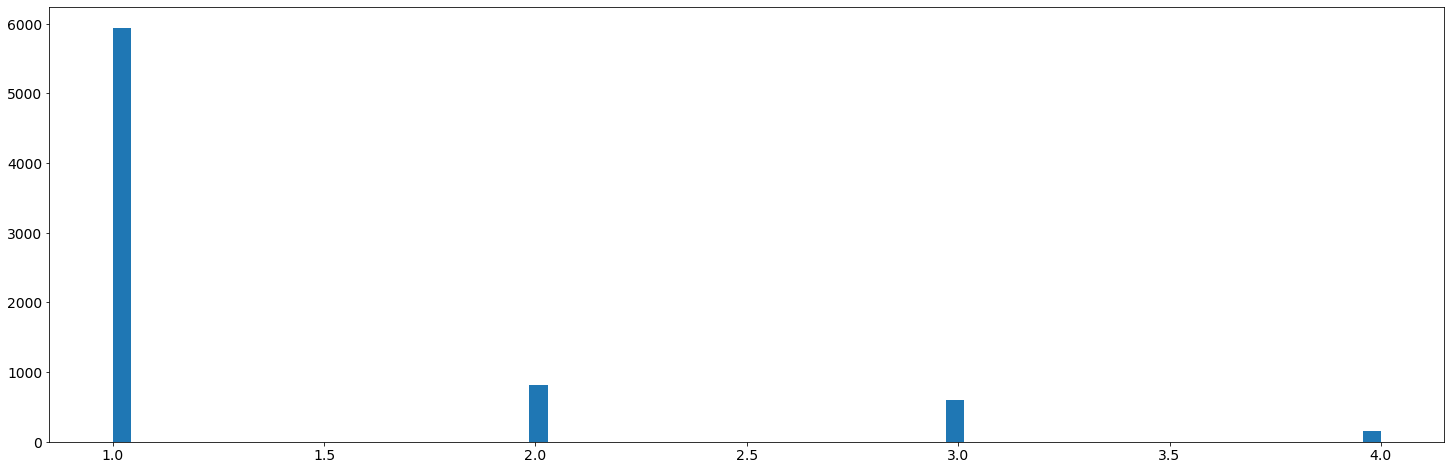

In [99]:
df_train['Purpose'].hist(figsize=(25, 8), bins=70, grid=False);

**Term** 

In [100]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

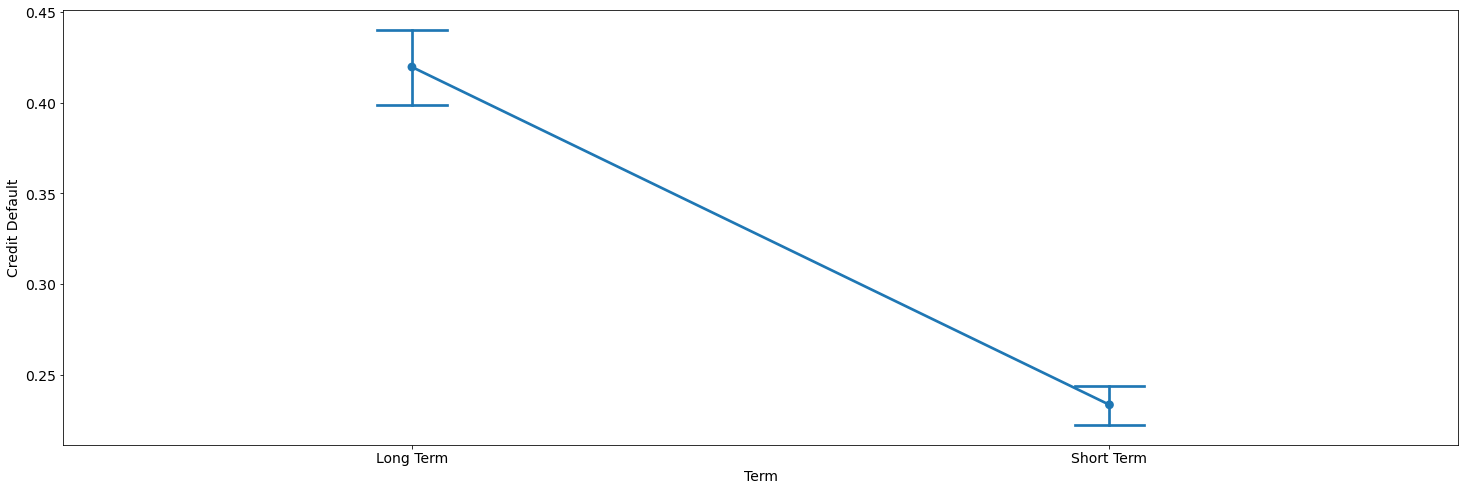

In [101]:
plt.figure(figsize=(25, 8))
sns.pointplot(x='Term', y='Credit Default', data=df_train, capsize=.1,)

In [102]:
df_train['Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [103]:
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

**Current Loan Amount**

In [104]:
df_train['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
270226.0         5
              ... 
490006.0         1
404756.0         1
194414.0         1
420376.0         1
33792.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

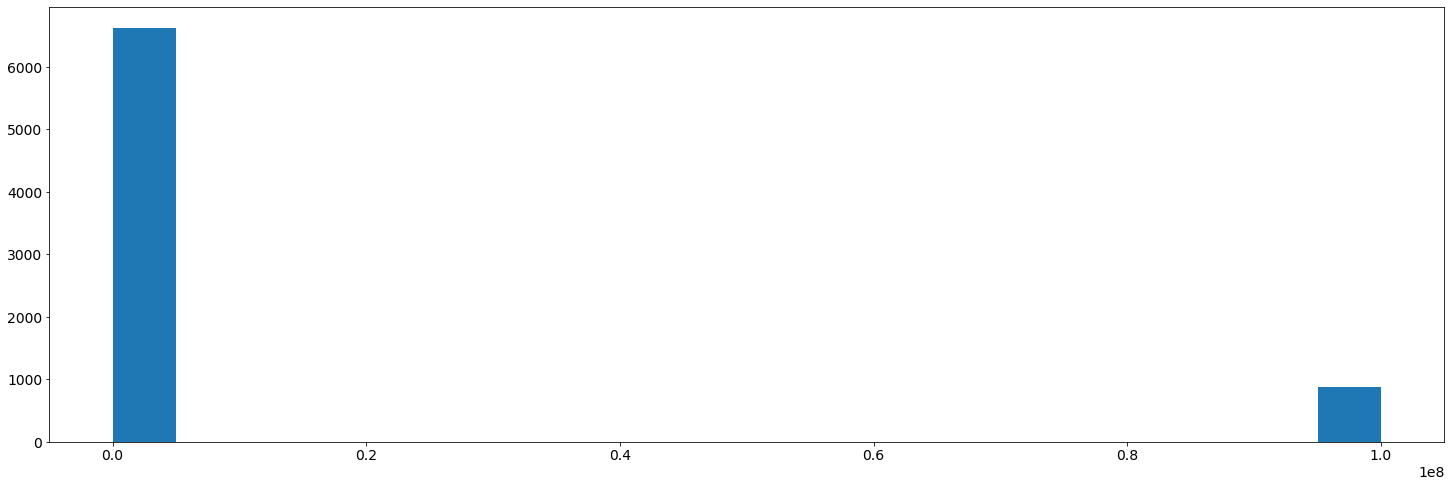

In [105]:
df_train['Current Loan Amount'].hist(figsize=(25, 8), bins=20, grid=False);

In [106]:
df_train['Current Loan Amount'].quantile(.95), df_train['Current Loan Amount'].quantile(.025)

(100000000.0, 57750.55000000001)

In [107]:
df_train['Current Loan Amount'].median()

309573.0

In [108]:
df_train.loc[df_train['Current Loan Amount'] >= np.quantile(df_train['Current Loan Amount'], q=0.95),\
             'Current Loan Amount'] = df_train['Current Loan Amount'].median()

In [109]:
df_test.loc[df_test['Current Loan Amount'] >= np.quantile(df_test['Current Loan Amount'], q=0.95),\
             'Current Loan Amount'] = df_test['Current Loan Amount'].median()

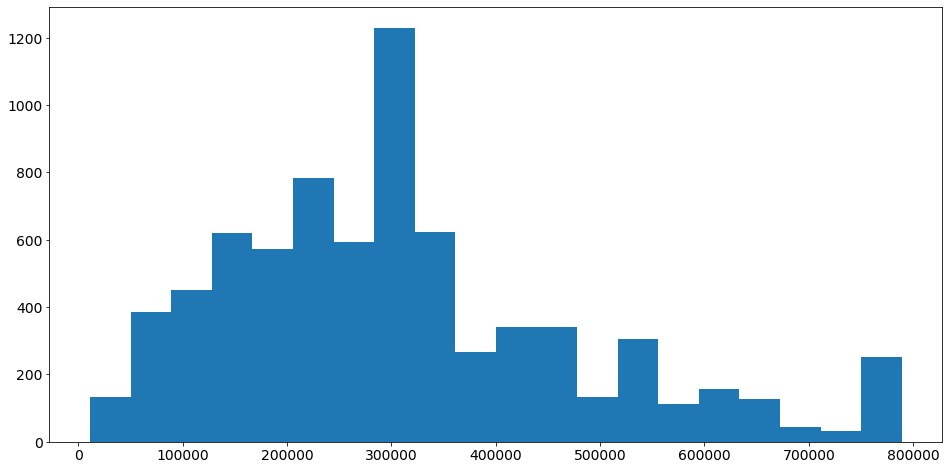

In [110]:
df_train['Current Loan Amount'].hist(figsize=(16, 8), bins=20, grid=False);

**Current Credit Balance**

In [111]:
df_train['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

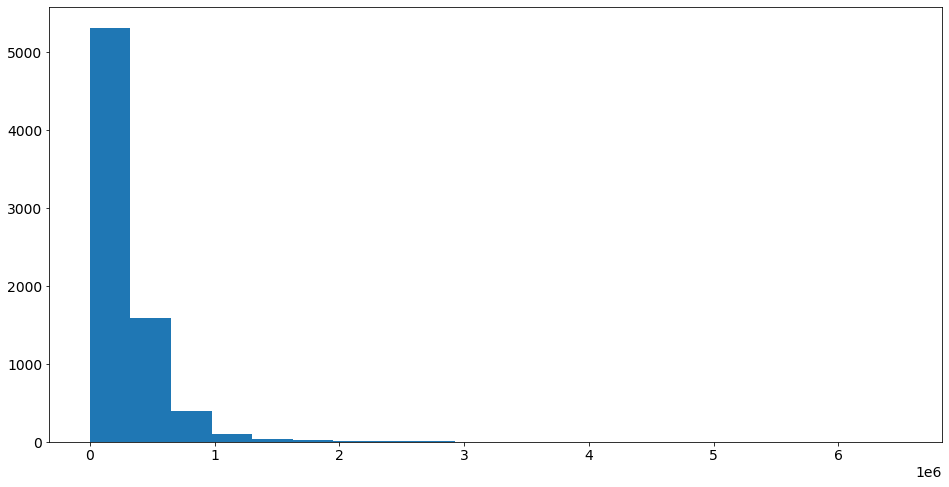

In [112]:
df_train['Current Credit Balance'].hist(figsize=(16, 8), bins=20, grid=False)

In [113]:
df_train['Current Credit Balance'].quantile(.975), df_train['Current Credit Balance'].quantile(.025)

(1001579.7749999975, 11970.0)

In [114]:
condition = (df_train['Current Credit Balance'].isna()) \
             | (df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.975))
        
df_train.loc[condition, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()

In [115]:
condition = (df_test['Current Credit Balance'].isna()) \
             | (df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.975))
        
df_test.loc[condition, 'Current Credit Balance'] = df_test['Current Credit Balance'].median()

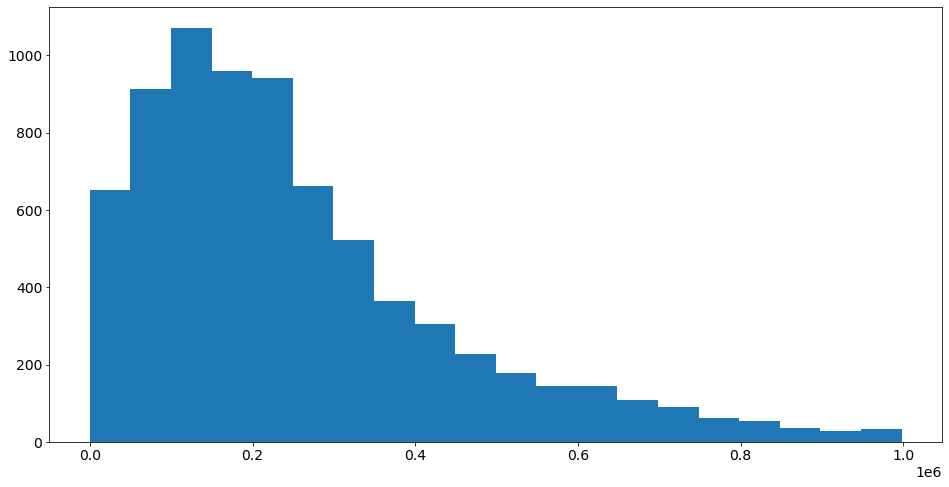

In [116]:
df_train['Current Credit Balance'].hist(figsize=(16, 8), bins=20, grid=False);

**Monthly Debt**

In [117]:
df_train['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

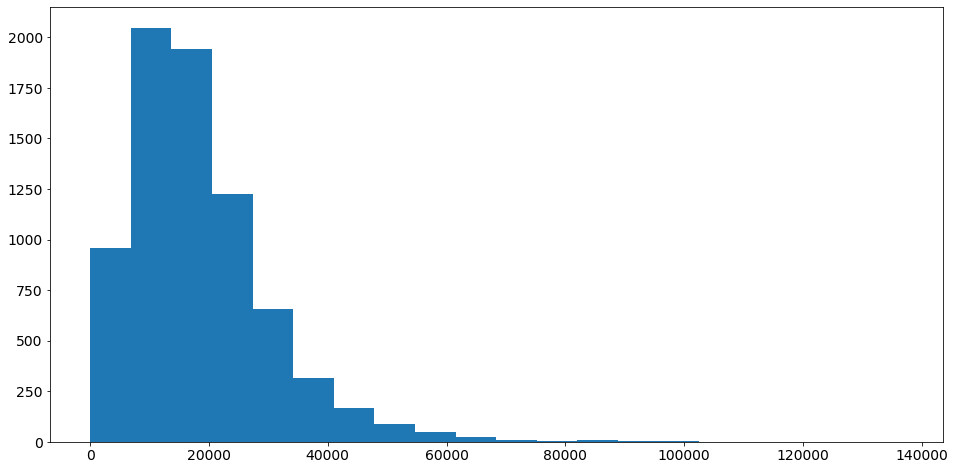

In [118]:
df_train['Monthly Debt'].hist(figsize=(16, 8), bins=20, grid=False);

In [119]:
df_train['Monthly Debt'].quantile(.975), df_train['Monthly Debt'].quantile(.025)

(47950.149999999965, 2433.9500000000003)

In [120]:
condition = (df_train['Monthly Debt'].isna()) \
             | (df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(.975))
        
df_train.loc[condition, 'Monthly Debt'] = df_train['Monthly Debt'].median()

In [121]:
condition = (df_test['Monthly Debt'].isna()) \
             | (df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.975))
        
df_test.loc[condition, 'Monthly Debt'] = df_test['Monthly Debt'].median()

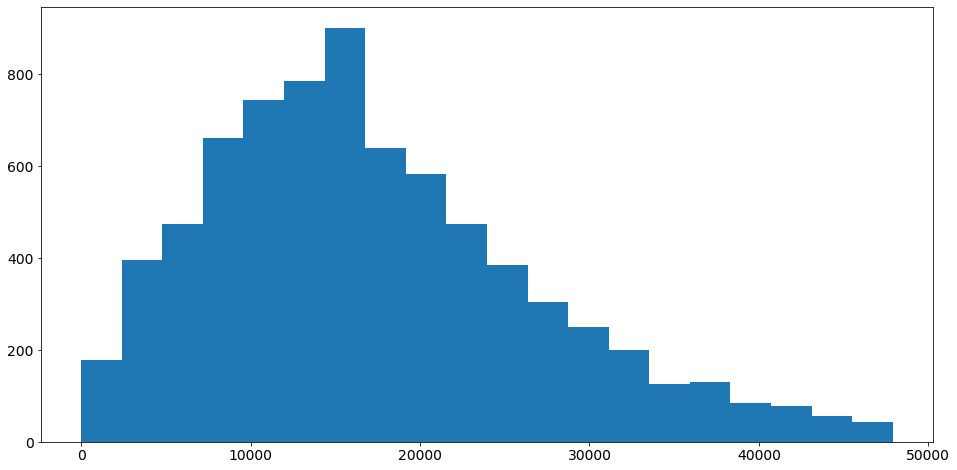

In [122]:
df_train['Monthly Debt'].hist(figsize=(16, 8), bins=20, grid=False);

**Annual Income**

In [123]:
df_train['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

In [124]:
df_train['Annual Income'].isna().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

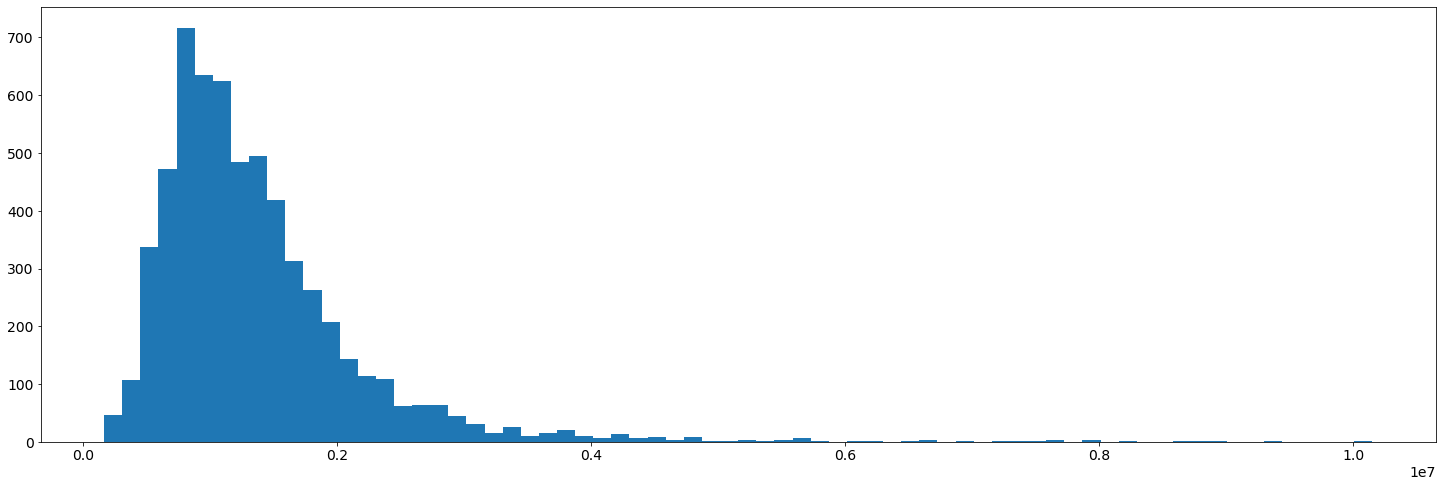

In [125]:
df_train['Annual Income'].hist(figsize=(25, 8), bins=70, grid=False);

In [126]:
# Переменная для идентификации пропусков
df_train['Annual Income Nan'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income Nan'] = 1

In [127]:
df_test['Annual Income Nan'] = 0
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income Nan'] = 1

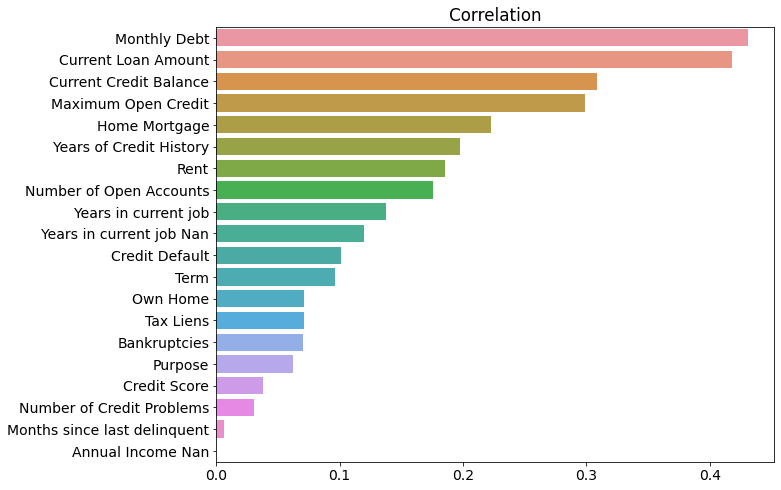

In [128]:
FEATURE_NAMES = df_train.columns.drop('Annual Income').tolist()
corr_Annual_Income = df_train[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [129]:
# Выберем признаки с наибольшей корреляцией
TARGET_FEATURE = list(corr_Annual_Income.index[0:10])

In [130]:
data = df_train.loc[(df_train['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Monthly Debt              5943 non-null   float32
 1   Current Loan Amount       5943 non-null   float32
 2   Current Credit Balance    5943 non-null   float32
 3   Maximum Open Credit       5943 non-null   float32
 4   Home Mortgage             5943 non-null   int64  
 5   Years of Credit History   5943 non-null   float32
 6   Rent                      5943 non-null   int64  
 7   Number of Open Accounts   5943 non-null   float32
 8   Years in current job      5943 non-null   int64  
 9   Years in current job Nan  5943 non-null   int64  
 10  Annual Income             5943 non-null   float32
dtypes: float32(7), int64(4)
memory usage: 394.7 KB


In [132]:
# Для заполнения пропусков используем LogisticRegression
model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
df_train.loc[(df_train['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_train.loc[(df_train['Annual Income'].isnull()), TARGET_FEATURE])

In [134]:
df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [135]:
df_train['Annual Income'].isna().value_counts()

False    7500
Name: Annual Income, dtype: int64

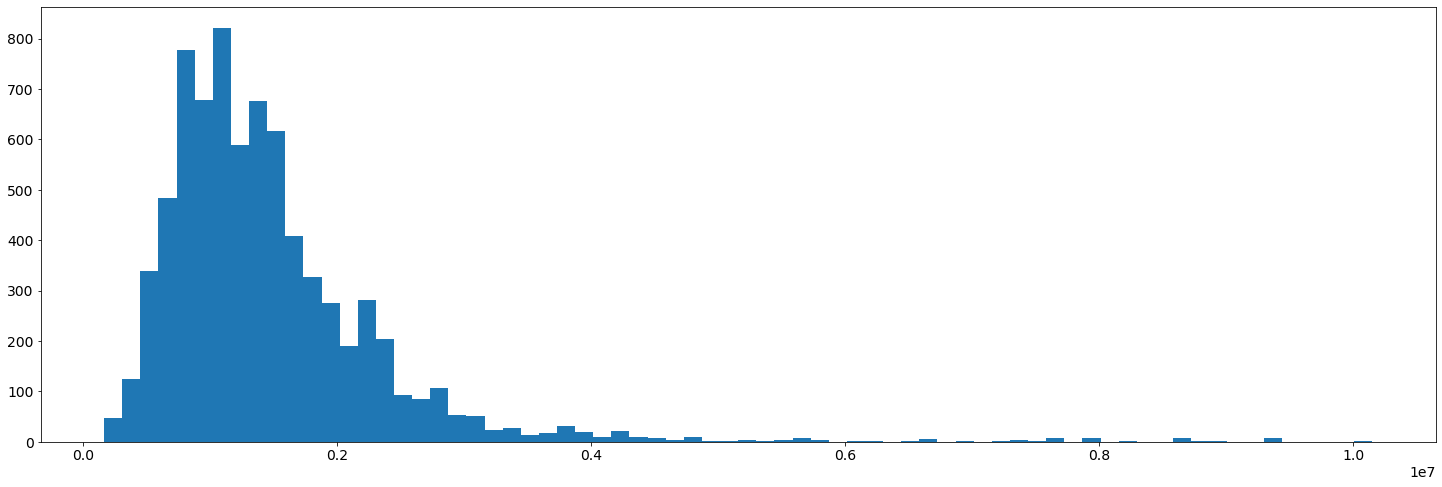

In [136]:
df_train['Annual Income'].hist(figsize=(25, 8), bins=70, grid=False);

**Credit Score**

In [137]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

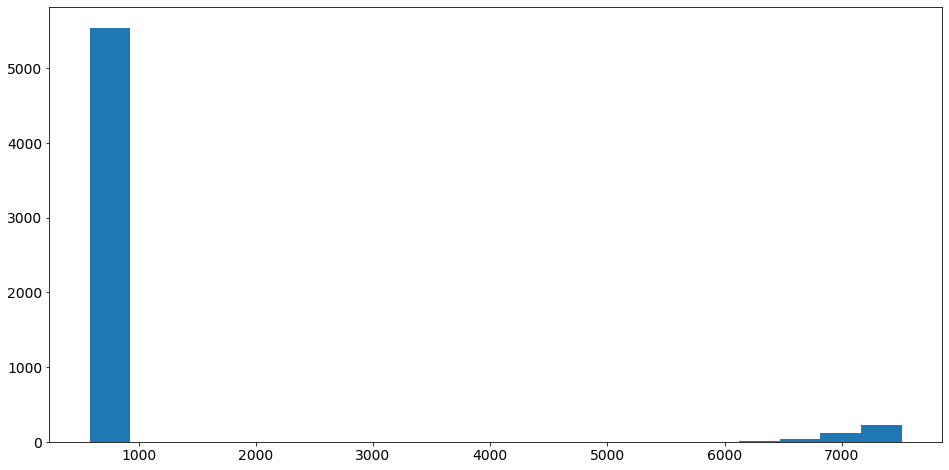

In [138]:
df_train['Credit Score'].hist(figsize=(16, 8), bins=20, grid=False);

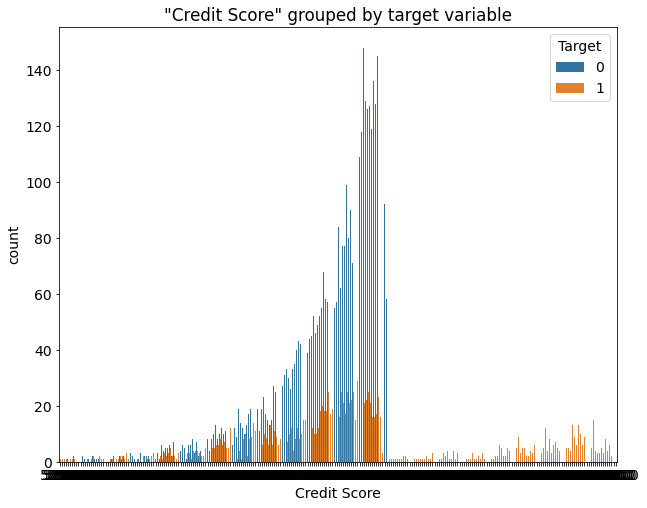

In [139]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue="Credit Default", data=df_train)
plt.title('\"Credit Score\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()


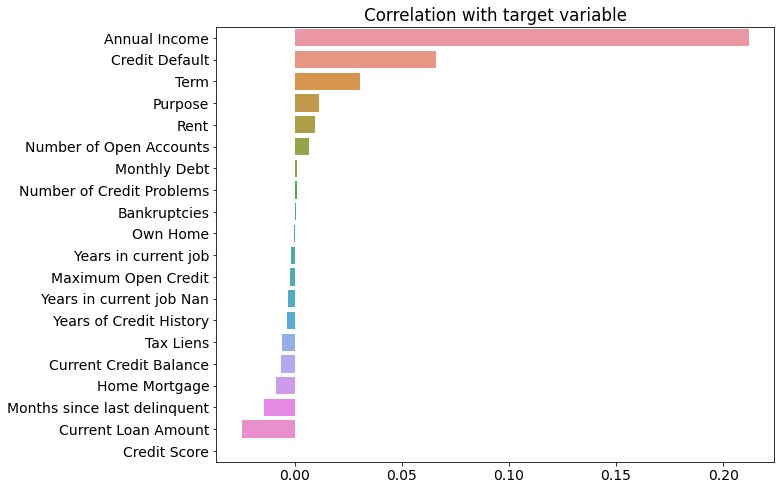

In [140]:
corr_credit_score = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)


plt.figure(figsize=(10, 8))

sns.barplot(x=corr_credit_score.values, y=corr_credit_score.index)

plt.title('Correlation with target variable')
plt.show()

In [141]:
df_train['Credit Score'].isna().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [142]:
# Выберем признаки с наибольшей корреляцией
TARGET_FEATURE = ['Purpose', 'Term', 'Annual Income',
                  'Rent', 'Number of Open Accounts']

In [143]:
data = df_train.loc[(df_train['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Purpose                  5943 non-null   int64  
 1   Term                     5943 non-null   int64  
 2   Annual Income            5943 non-null   float32
 3   Rent                     5943 non-null   int64  
 4   Number of Open Accounts  5943 non-null   float32
 5   Credit Score             5943 non-null   float32
dtypes: float32(3), int64(3)
memory usage: 255.4 KB


In [145]:
model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
df_train.loc[(df_train['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_train.loc[(df_train['Credit Score'].isnull()), TARGET_FEATURE])

In [147]:
df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

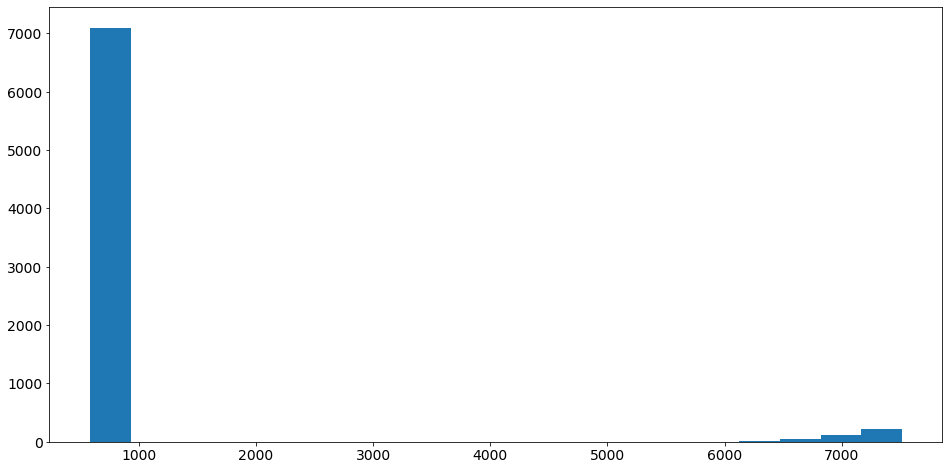

In [148]:
df_train['Credit Score'].hist(figsize=(16, 8), bins=20
                              , grid=False);

In [149]:
df_train['Credit Score'].quantile(.975), df_train['Credit Score'].quantile(.025)

(7215.249999999996, 653.0)

In [150]:
condition = (df_train['Credit Score'].isna()) \
             | (df_train['Credit Score'] > df_train['Credit Score'].quantile(.975))
        
df_train.loc[condition, 'Credit Score'] = df_train['Credit Score'].median()

In [151]:
condition = (df_test['Credit Score'].isna()) \
             | (df_test['Credit Score'] > df_test['Credit Score'].quantile(.975))
        
df_test.loc[condition, 'Credit Score'] = df_test['Credit Score'].median()

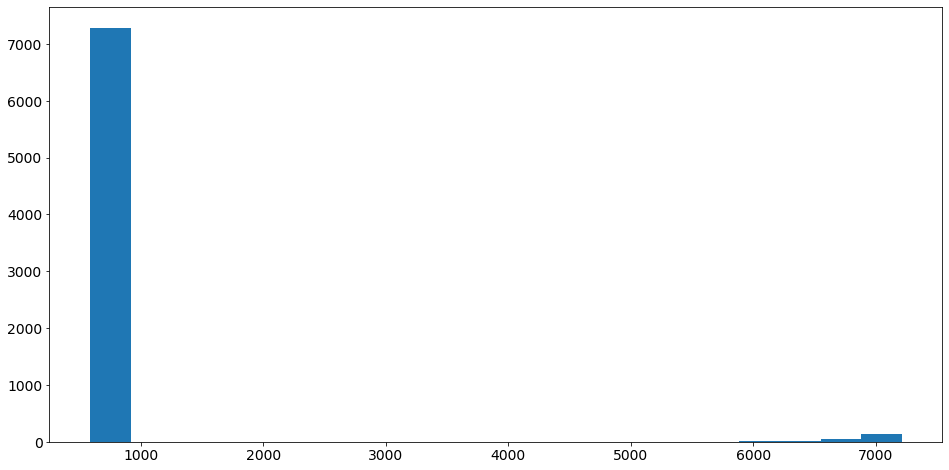

In [152]:
df_train['Credit Score'].hist(figsize=(16, 8), bins=20
                              , grid=False);

In [153]:
df_train['Credit Score'].isna().value_counts()

False    7500
Name: Credit Score, dtype: int64

In [154]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float32
 1   Years in current job          7500 non-null   int64  
 2   Tax Liens                     7500 non-null   int64  
 3   Number of Open Accounts       7500 non-null   float32
 4   Years of Credit History       7500 non-null   float32
 5   Maximum Open Credit           7500 non-null   float32
 6   Number of Credit Problems     7500 non-null   int64  
 7   Months since last delinquent  7500 non-null   float32
 8   Bankruptcies                  7500 non-null   float32
 9   Purpose                       7500 non-null   int64  
 10  Term                          7500 non-null   int64  
 11  Current Loan Amount           7500 non-null   float32
 12  Current Credit Balance        7500 non-null   float32
 13  Mon

In [155]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = ['Home Mortgage', 'Rent', 'Own Home', 'Years in current job Nan', 'Annual Income Nan'    ]
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Purpose','Term']

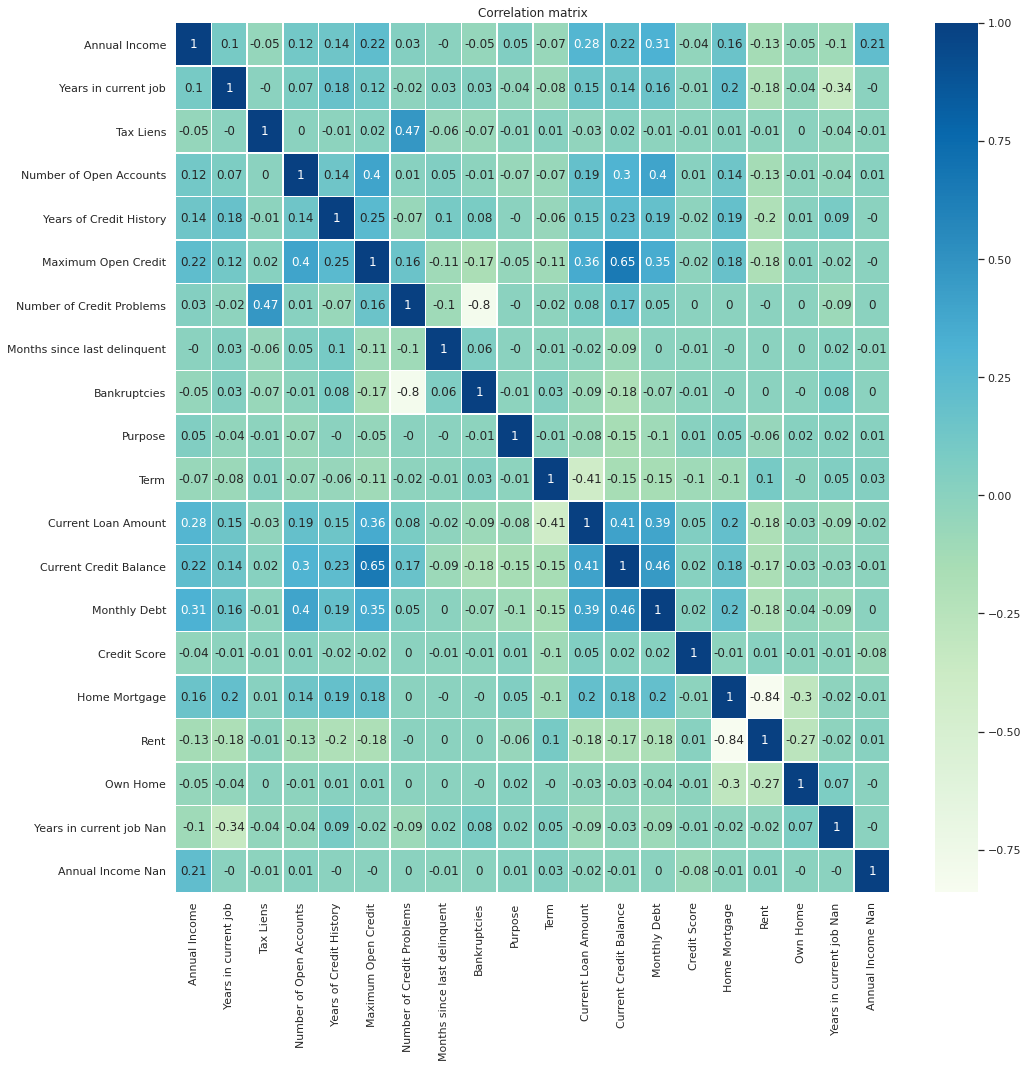

In [156]:
plt.figure(figsize = (16,16))

sns.set(font_scale=1)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(2), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix');

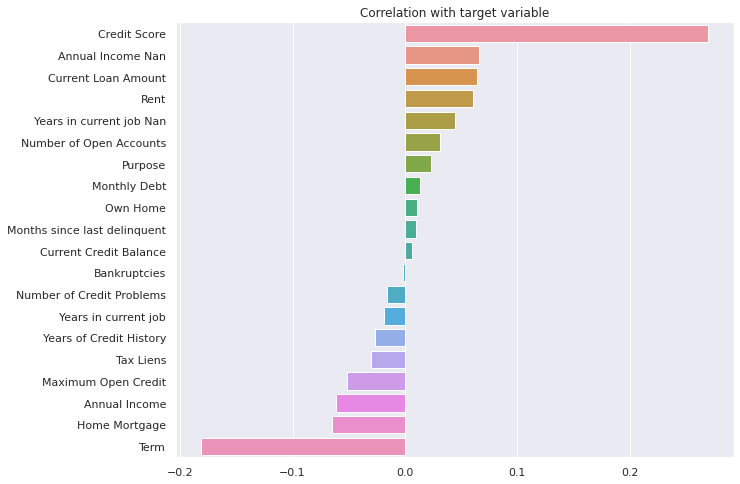

In [157]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable');

In [158]:
df_train.columns.tolist()

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Mortgage',
 'Rent',
 'Own Home',
 'Years in current job Nan',
 'Annual Income Nan']

In [159]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Years in current job', 'Tax Liens', 'Number of Credit Problems']

NEW_FEATURE_NAMES = ['Bankruptcies', 'Term', 'Home Mortgage', 'Rent', 'Own Home',
                     'Years in current job Nan', 'Annual Income Nan']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

In [160]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [161]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [162]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

# **Используем модель CatBoost**

In [163]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3771
           1       0.96      0.58      0.72      1479

    accuracy                           0.87      5250
   macro avg       0.91      0.79      0.82      5250
weighted avg       0.89      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.94      0.84      1616
           1       0.64      0.29      0.40       634

    accuracy                           0.75      2250
   macro avg       0.70      0.61      0.62      2250
weighted avg       0.73      0.75      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1511  105
1                450  184
CPU times: user 8.04 s, sys: 537 ms, total: 8.58 s
Wall time: 5.46 s


In [164]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3771
           1       0.93      0.51      0.66      1479

    accuracy                           0.85      5250
   macro avg       0.88      0.75      0.78      5250
weighted avg       0.86      0.85      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1616
           1       0.67      0.30      0.41       634

    accuracy                           0.76      2250
   macro avg       0.72      0.62      0.63      2250
weighted avg       0.74      0.76      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1523   93
1                446  188


In [165]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [166]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3771
           1       0.71      0.86      0.78      1479

    accuracy                           0.86      5250
   macro avg       0.83      0.86      0.84      5250
weighted avg       0.88      0.86      0.87      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1616
           1       0.46      0.56      0.51       634

    accuracy                           0.69      2250
   macro avg       0.64      0.65      0.64      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1204  412
1                276  358


In [167]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [168]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [169]:
params = {'iterations':[200, 300, 500],
          'max_depth':[3, 5, 7]}

In [170]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [171]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5145528547
bestIteration = 0

0:	loss: 0.5145529	best: 0.5145529 (0)	total: 162ms	remaining: 1.29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5145528547
bestIteration = 0

1:	loss: 0.5145529	best: 0.5145529 (0)	total: 278ms	remaining: 974ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5145528547
bestIteration = 0

2:	loss: 0.5145529	best: 0.5145529 (0)	total: 392ms	remaining: 783ms

bestTest = 0.6467632804
bestIteration = 195

3:	loss: 0.6467633	best: 0.6467633 (3)	total: 2.09s	remaining: 2.61s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6551770244
bestIteration = 212

4:	loss: 0.6551770	best: 0.6551770 (4)	total: 3.91s	remaining: 3.13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6551770244
bestIteration = 212

5:	loss: 0.6551770	best: 0.6551770 (4)	total: 5.73s	remaining: 2.87s

bestTest = 0.6473615178
bestIteration = 197



In [172]:
grid_search

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20],
              'test-F1-mean': [0.5635849463096901,
               0.5493707201686183,
               0.5461817061418451,
               0.5375946291312586,
               0.5357827128361644,
               0.5413687620407438,
               0.5350704270181424,
               0.5375327475900101,
               0.5368966099288865,
               0.5365566057847024,
               0.5369545028156525,
               0.5373304886469343,
               0.5365027308398744,
               0.5401567761184423,
               0.5469277537226321,
               0.55487

In [173]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.74      0.79      3771
           1       0.51      0.70      0.59      1479

    accuracy                           0.73      5250
   macro avg       0.68      0.72      0.69      5250
weighted avg       0.76      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1616
           1       0.45      0.63      0.52       634

    accuracy                           0.68      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1123  493
1                236  398
CPU times: user 1.35 s, sys: 72.6 ms, total: 1.42 s
Wall time: 916 ms


In [174]:
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print(f1_score(y_test, y_test_pred))

0.5163535142658316


In [175]:
test_output = final_model.predict(df_test[SELECTED_FEATURE_NAMES])

In [176]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': test_output})

In [178]:
RESULT_PATH='./BykovKirill_predictions.csv'
result.to_csv(RESULT_PATH, index=False)